In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm

# Dataset preparation

**Data transforms**

In [2]:
class SaltAndPepperNoise:
    def __init__(self, salt_proportion=0.1, pepper_proportion=0.1):
        self.salt_proportion = salt_proportion
        self.pepper_proportion = pepper_proportion
        
    def __call__(self, image):
        return self._add_pepper_noise(self._add_salt_noise(image))
        
    def _add_salt_noise(self, image):
        indices = np.random.randint(low=0, high=image.size, size=int(image.size * self.salt_proportion))
        flattened_im = image.flatten()
        flattened_im[indices] = 255
        return flattened_im.reshape(image.shape)
    
    def _add_pepper_noise(self, image):
        indices = np.random.randint(low=0, high=image.size, size=int(image.size * self.pepper_proportion))
        flattened_im = image.flatten()
        flattened_im[indices] = 0
        return flattened_im.reshape(image.shape)
    
class Reshape:
    def __init__(self, shape):
        self.shape = shape
        
    def __call__(self, image):
        return image.reshape(self.shape)

**Dataset class**

In [3]:
class MNISTImages(Dataset):
    def __init__(self, noise_transform=None):
        train_data = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_train.csv")
        test_data = pd.read_csv("/kaggle/input/mnist-in-csv/mnist_test.csv")
        train_data = train_data.iloc[:, 1:].to_numpy()
        test_data = test_data.iloc[:, 1:].to_numpy()
        self.data = np.concatenate([train_data, test_data], axis=0).astype(np.uint8)
        self.noise_transform = noise_transform
        self.im_shape = 28, 28
        self.reshape = Reshape(self.im_shape)
        self.to_tensor = transforms.ToTensor()
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, ind):
        im = self.reshape(self.data[ind, :])
        if self.noise_transform:
            noised_image = self.noise_transform(np.copy(im))
        else:
            noised_image = np.copy(im)
        return self.to_tensor(noised_image), self.to_tensor(im)

In [4]:
dataset = MNISTImages(noise_transform=SaltAndPepperNoise())

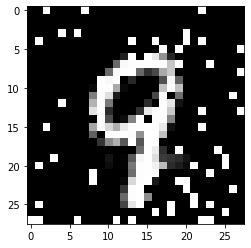

In [5]:
plt.imshow(dataset[np.random.randint(0, len(dataset))][0][0], cmap='gray')

# Autoencoder models

In [6]:
class LinearAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(784, 256)
        self.linear2 = nn.Linear(256, 64)
        self.linear3 = nn.Linear(64, 256)
        self.linear4 = nn.Linear(256, 784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Unflatten(1, (1, 28, 28)),
            nn.Sigmoid(),
        )

        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [7]:
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_dim = 100
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 16, 3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, self.hidden_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(self.hidden_dim, 16 * 5 * 5),
            nn.Unflatten(1, (16, 5, 5)),
            nn.ConvTranspose2d(16, 32, 3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, 3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 1, 3, stride=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(1, 1, 4, stride=1),
            nn.Sigmoid()
        )
    
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Training loop

In [8]:
def train_model(model, dataloader, epochs_num=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs_num):
        print(f'Epoch {epoch}')
        with tqdm(total=len(dataloader)) as pbar:
            for index, batch in enumerate(dataloader):
                noisy_im, clean_im = batch
                output = model(noisy_im.to(device))
                loss = loss_function(output, clean_im)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                pbar.set_description_str("Loss = {}".format(loss.item()))
                pbar.update()
                
    return model

In [9]:
batch_size = 512
dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
linear_autoencoder = train_model(LinearAutoEncoder(), dataloader, epochs_num=15)

Epoch 0


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/137 [00:00<?, ?it/s]

In [10]:
conv_autoencoder = train_model(ConvAutoEncoder(), dataloader, epochs_num=15)

Epoch 0


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 10


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 11


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 12


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 13


  0%|          | 0/137 [00:00<?, ?it/s]

Epoch 14


  0%|          | 0/137 [00:00<?, ?it/s]

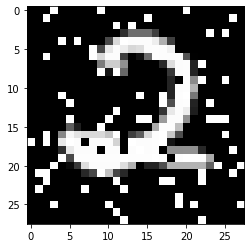

In [11]:
selected_image = dataset[np.random.randint(0, len(dataset))][0][0]
plt.imshow(selected_image, cmap='gray')

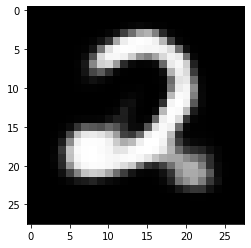

In [12]:
output = linear_autoencoder(selected_image.unsqueeze(0).unsqueeze(0)).detach().squeeze().numpy()
plt.imshow(output, cmap='gray')

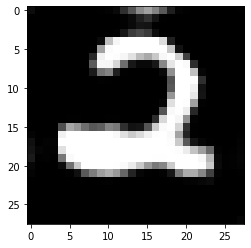

In [13]:
output = conv_autoencoder(selected_image.unsqueeze(0).unsqueeze(0)).detach().squeeze().numpy()
plt.imshow(output, cmap='gray')